In [1]:
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

path='dataset'
images=[]
classNo=[]
testRatio=0.2
valRatio=0.2
imgDimension=(32,32,3)

In [2]:
myList=os.listdir(path)

numOfClasses=len(myList)

print("Importing Classes..........")
for x in range(0, numOfClasses):
	myPicList=os.listdir(path+"/"+str(x))
	for y in myPicList:
		curImg=cv2.imread(path+"/"+str(x)+"/"+y)
		curImg=cv2.resize(curImg,(imgDimension[0],imgDimension[1]))
		images.append(curImg)
		classNo.append(x)
	print(x)

images=np.array(images)
classNo=np.array(classNo)

Importing Classes..........
0
1
2
3
4
5
6
7
8
9


In [3]:
x_train, x_test, y_train, y_test=train_test_split(images, classNo, test_size=testRatio)
x_train, x_validation, y_train, y_validation=train_test_split(x_train, y_train, test_size=valRatio)

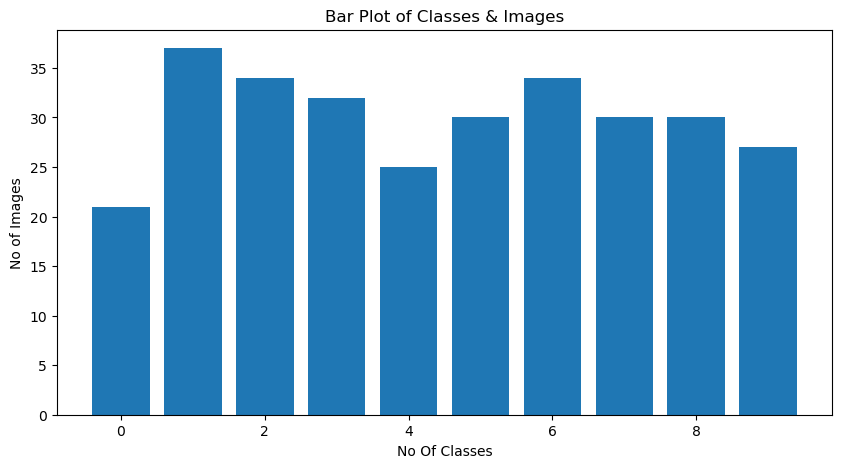

In [4]:
numOfSample=[]

for x in range(0,numOfClasses):
	numOfSample.append(len(np.where(y_train==x)[0]))


plt.figure(figsize=(10,5))
plt.bar(range(0, numOfClasses),numOfSample)
plt.title("Bar Plot of Classes & Images")
plt.xlabel("No Of Classes")
plt.ylabel("No of Images")
plt.show()

In [5]:
def preprocessing(img):
	# img=np.astype("uint8")
	img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	_, img = cv2.threshold(img, 170, 255, cv2.THRESH_BINARY)
	img=cv2.equalizeHist(img)
	img=img/255
	return img


x_train=np.array(list(map(preprocessing, x_train)))
x_test=np.array(list(map(preprocessing, x_test)))
x_validation=np.array(list(map(preprocessing, x_validation)))

In [6]:
x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2],1)
x_test=x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2],1)
x_validation=x_validation.reshape(x_validation.shape[0], x_validation.shape[1], x_validation.shape[2],1)


dataGen=ImageDataGenerator(
	width_shift_range=0.1,
	height_shift_range=0.1,
	zoom_range=0.2,
	shear_range=0.1,
	rotation_range=10)

dataGen.fit(x_train)

y_train=to_categorical(y_train, numOfClasses)
y_test=to_categorical(y_test, numOfClasses)
y_validation=to_categorical(y_validation, numOfClasses)

In [7]:
def myModel():
	noOfFilters=60
	sizeOfFilter1=(5,5)
	sizeOfFilter2=(3,3)
	sizeOfPool=(2,2)
	noOfNode=50

	model=Sequential()
	model.add((Conv2D(noOfFilters, sizeOfFilter1, input_shape=(imgDimension[0],imgDimension[1],1),activation='relu')))
	model.add((Conv2D(noOfFilters, sizeOfFilter1,activation='relu')))
	model.add(MaxPooling2D(pool_size=sizeOfPool))

	model.add((Conv2D(noOfFilters//2, sizeOfFilter2,activation='relu')))
	model.add((Conv2D(noOfFilters//2, sizeOfFilter2,activation='relu')))
	model.add(MaxPooling2D(pool_size=sizeOfPool))
	model.add(Dropout(0.5))


	model.add(Flatten())
	model.add(Dense(noOfNode, activation='relu'))
	model.add(Dropout(0.5))
	model.add(Dense(numOfClasses, activation='softmax'))
	model.compile(Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
	return model

model=myModel()
print(model.summary())

history=model.fit(dataGen.flow(x_train, y_train,batch_size=50),
	steps_per_epoch=2000,
	epochs=5,
	validation_data=(x_validation,y_validation),
	shuffle=1)

model.save("BanglaModel.h5")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        24,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,540 (548.98 KB)

 Trainable params: 140,540 (548.98 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 399us/step - accuracy: 0.1067 - loss: 2.3167 - val_accuracy: 0.0526 - val_loss: 2.3081
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - accuracy: 0.1099 - loss: 2.2978 - val_accuracy: 0.0526 - val_loss: 2.3190
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - accuracy: 0.1167 - loss: 2.3036 - val_accuracy: 0.0526 - val_loss: 2.3246
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - accuracy: 0.1333 - loss: 2.2963 - val_accuracy: 0.0658 - val_loss: 2.3298
Epoch 5/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 202us/step - accuracy: 0.1067 - loss: 2.2979 - val_accuracy: 0.0526 - val_loss: 2.3300


In [8]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.0514 - loss: 2.3194
Test loss: 2.3186697959899902
Test accuracy: 0.06382978707551956
